In [1]:
import sqlite3
import datetime
import nltk
import pymorphy2
import ftfy
import re
import dill

import numpy as np
import pandas as pd

from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, LabelEncoder, Imputer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score

dill.settings['recurse']=True

In [2]:
conn = sqlite3.connect("vk.db")
df = pd.read_sql("""SELECT u.*, p.posts
                    FROM Users AS u
                    LEFT JOIN (SELECT from_id, group_concat(text) AS posts
                          FROM Posts
                          GROUP BY from_id) AS p
                    ON u.id = p.from_id""", conn)
conn.close()

In [3]:
df.set_index("id", inplace=True)

In [4]:
len(df.dropna(axis=0, thresh=2))

15393

In [5]:
df.dropna(axis=0, thresh=2, inplace=True)

So, out of 25k collected users we have only 15393 that have any information except sex (actually, it's a users's decision to hide their profile from anything they haven't authorized explicitly)

In [6]:
df.head()

,sex,bdate,activities,interests,music,movies,tv,books,games,about,quotes,posts
id,,,,,,,,,,,,
1,2,10.10.1984,None,None,None,12 Angry Men,None,None,None,None,"Being free, being truly free consists of not b...",Visions are worth fighting for. Why spend your...
5,2,18.11,None,None,None,None,None,None,None,None,None,"Уезжаем из Петербурга на 10 дней .,Svershilos...."
8,2,None,▄██▄██▄░██░░░▄█▀▀█▄░█▌░░▐█░██▀▀▀░▄██▄██▄ ▀████...,▄██▄██▄░██░░░▄█▀▀█▄░█▌░░▐█░██▀▀▀░▄██▄██▄ ▀████...,▄██▄██▄░██░░░▄█▀▀█▄░█▌░░▐█░██▀▀▀░▄██▄██▄ ▀████...,▄██▄██▄░██░░░▄█▀▀█▄░█▌░░▐█░██▀▀▀░▄██▄██▄ ▀████...,▄██▄██▄░██░░░▄█▀▀█▄░█▌░░▐█░██▀▀▀░▄██▄██▄ ▀████...,▄██▄██▄░██░░░▄█▀▀█▄░█▌░░▐█░██▀▀▀░▄██▄██▄ ▀████...,▄██▄██▄░██░░░▄█▀▀█▄░█▌░░▐█░██▀▀▀░▄██▄██▄ ▀████...,▄██▄██▄░██░░░▄█▀▀█▄░█▌░░▐█░██▀▀▀░▄██▄██▄ ▀████...,▄██▄██▄░██░░░▄█▀▀█▄░█▌░░▐█░██▀▀▀░▄██▄██▄ ▀████...,Утепление квартир. \n380951216778\nкачественно...
9,1,None,Не до неё :),"Активный отдых на природе, охрана природы и эк...",svoeradio.fm,"Форрест Гамп, Властелин Колец, Алые паруса, Ос...",Что это?,"""Книга об отце"" Лив Нансен-Хейер, ""Фрам в поля...",Жизнь,"»\n— Вы сумасшедший?\n— Напротив, я так нормал...","Охохо!\n(Катя-some)\n\nJa,ja das ist phantasti...","пью йад.,""дайте мне мой кусок жизни, пока я не..."
10,2,None,None,None,None,None,None,None,None,None,None,"дамы, не читайте мою стену, пожалуйста.,обозва..."


In [7]:
len(df[df.bdate.str.contains("\d{1,2}\.\d{1,2}\.\d{4}") == True])

8570

We have 8570 entries with complete birthday date  
Not much, but this might work out just fine

In [8]:
def get_entries_with_complete_bdate(data):
    return df[df.bdate.str.contains("\d{1,2}\.\d{1,2}\.\d{4}") == True]

In [9]:
def get_age_from_bdate(s):
    if s is None:
        return np.nan
    
    d = None
    try:
        d = datetime.datetime.strptime(s, "%d.%m.%Y")
    except ValueError:
        if len(s) > 4 and s[:4] == "29.2": # apparently, VK just can't perform leap years check reliably
            d = datetime.datetime.strptime("28.2." + s[-4:], "%d.%m.%Y")
    if d is not None:
        return (datetime.datetime.now() - d).days // 365.25
    return np.nan

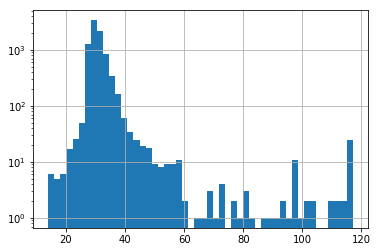

In [10]:
%matplotlib inline
get_entries_with_complete_bdate(df).bdate.apply(get_age_from_bdate).hist(bins=50, log=True)

Age distribution is very skewed to the 25-30 range with a peak at around 30   
It might be an inherent feature of this specific users subset (first 25k ids), because, obviously, these users have one trait in common — they are early adopters, they age may has something to do with it

In [11]:
len(df[df.sex != 0])

15393

And all users have their sex filled, good

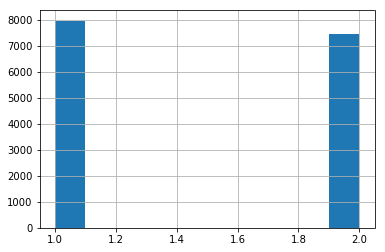

In [12]:
df.sex.hist()

Sex distribution is almost uniform, no problems here

In [13]:
train_age, test_age = train_test_split(get_entries_with_complete_bdate(df), test_size=.2, random_state=0, shuffle=True)

In [14]:
train_sex, test_sex = train_test_split(df, test_size=0.2, random_state=0, shuffle=True)

We need to transform all text features into TF-IDF form and train two models.  
Frist model will try to predict age using these features and sex, second one is going to predict sex using the same features and age.

In [15]:
def get_pipeline(for_age_prediction=False):
    
    ma = pymorphy2.MorphAnalyzer()
    stopwords = nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("russian")
    words_regex = re.compile(r"[\W]+")
    links_regex = re.compile(r"""\b((?:https?:\/\/|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}\/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))""")
    numbers_regex = re.compile("[0-9]+")
    
    def tokenize(s):
        s = s.lower()
        s = ftfy.fix_text(s)
        s = s.replace("\n", " ")
        s = links_regex.sub(" ", s).strip() # remove all links
        s = words_regex.sub(" ", s).strip() # extract words
        s = numbers_regex.sub(" ", s).strip() # remove numbers
        tokens = [ma.parse(w)[0].normal_form for w in s.split()] # get normalized words
        return [w for w in tokens if w not in stopwords] # exclude stopwords
    
    def get_var_col_pipeline():
        if for_age_prediction:
            return make_pipeline(FunctionTransformer(get_sex_col, validate=False), Imputer(strategy="most_frequent"))
        else:
            return make_pipeline(FunctionTransformer(get_age_col, validate=False), Imputer(), StandardScaler())
    
    def get_age_col(d):
        return d.bdate.apply(get_age_from_bdate).values.reshape(-1, 1)
    
    def get_sex_col(d):
        return (d[["sex"]].fillna(0.0) - 1.0).replace([-1.0], [np.nan])
    
    def get_activities_col(d):
        return d["activities"].fillna("None")
    
    def get_interests_col(d):
        return d["interests"].fillna("None")
    
    def get_music_col(d):
        return d["music"].fillna("None")
    
    def get_movies_col(d):
        return d["movies"].fillna("None")
    
    def get_tv_col(d):
        return d["tv"].fillna("None")
    
    def get_books_col(d):
        return d["books"].fillna("None")
    
    def get_games_col(d):
        return d["games"].fillna("None")
    
    def get_about_col(d):
        return d["about"].fillna("None")
    
    def get_quotes_col(d):
        return d["quotes"].fillna("None")
    
    def get_posts_col(d):
        return d["posts"].fillna("None")
    
    p = make_union(*[
        get_var_col_pipeline(),
        make_pipeline(FunctionTransformer(get_activities_col, validate=False),
                      TfidfVectorizer(max_features=1000, ngram_range=(1, 3), tokenizer=tokenize)),
        make_pipeline(FunctionTransformer(get_interests_col, validate=False),
                      TfidfVectorizer(max_features=1000, ngram_range=(1, 3), tokenizer=tokenize)),
        make_pipeline(FunctionTransformer(get_music_col, validate=False),
                      TfidfVectorizer(max_features=1000, ngram_range=(1, 3), tokenizer=tokenize)),
        make_pipeline(FunctionTransformer(get_movies_col, validate=False),
                      TfidfVectorizer(max_features=1000, ngram_range=(1, 3), tokenizer=tokenize)),
        make_pipeline(FunctionTransformer(get_tv_col, validate=False),
                      TfidfVectorizer(max_features=1000, ngram_range=(1, 3), tokenizer=tokenize)),
        make_pipeline(FunctionTransformer(get_books_col, validate=False),
                      TfidfVectorizer(max_features=1000, ngram_range=(1, 3), tokenizer=tokenize)),
        make_pipeline(FunctionTransformer(get_games_col, validate=False),
                      TfidfVectorizer(max_features=1000, ngram_range=(1, 3), tokenizer=tokenize)),
        make_pipeline(FunctionTransformer(get_about_col, validate=False),
                      TfidfVectorizer(max_features=1000, ngram_range=(1, 3), tokenizer=tokenize)),
        make_pipeline(FunctionTransformer(get_quotes_col, validate=False),
                      TfidfVectorizer(max_features=1000, ngram_range=(1, 3), tokenizer=tokenize)),
        make_pipeline(FunctionTransformer(get_posts_col, validate=False),
                      TfidfVectorizer(max_features=1000, ngram_range=(1, 3), tokenizer=tokenize))
    ])
    return p

Model will learn from new users, requested over time, so we need to choose models that support `partial_fit`  
Given this constraint, SGDRegressor and SGDClassifier are good candidates

In [16]:
pipeline_age = get_pipeline(True)
X_age, y_age = pipeline_age.fit_transform(train_age), train_age.bdate.apply(get_age_from_bdate)
X_age_test, y_age_test = pipeline_age.transform(test_age), test_age.bdate.apply(get_age_from_bdate)

In [17]:
age_params = {
                "loss" : ["squared_loss", "huber"],
                "penalty" : ["l2", "l1", "elasticnet"],
                "alpha" : [0.001, 0.01, 0.1, 1],
                "l1_ratio" : [0.25, 0.5, 0.75],
                "max_iter" : [10000],
                "random_state" : [0]
             }

In [18]:
gs_age = GridSearchCV(SGDRegressor(), age_params, cv=10, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
gs_age.fit(X_age, y_age)
print(gs_age.best_score_)
age_model = gs_age.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 42.2min finished


-48.4971275552


In [19]:
pipeline_sex = get_pipeline()
X_sex, y_sex = pipeline_sex.fit_transform(train_sex), train_sex.sex - 1.0
X_sex_test, y_sex_test = pipeline_sex.transform(test_sex), test_sex.sex - 1.0

In [20]:
sex_params = age_params.copy()
sex_params["loss"] = ["hinge", "log", "modified_huber"]

In [21]:
gs_sex = GridSearchCV(SGDClassifier(), sex_params, cv=10, scoring='roc_auc', verbose=1, n_jobs=-1)
gs_sex.fit(X_sex, y_sex)
print(gs_sex.best_score_)
sex_model = gs_sex.best_estimator_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 73.8min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 101.8min finished


0.564710700269


In [22]:
age_model

SGDRegressor(alpha=0.1, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.25, learning_rate='invscaling',
       loss='squared_loss', max_iter=10000, n_iter=None,
       penalty='elasticnet', power_t=0.25, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [23]:
sex_model

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.25,
       learning_rate='optimal', loss='modified_huber', max_iter=10000,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=0,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [24]:
age_preds = age_model.predict(X_age_test)
age_mse = mean_squared_error(y_age_test, age_preds)
age_mse

63.754040568235112

In [25]:
sex_preds = sex_model.predict(X_sex_test)
sex_auc = roc_auc_score(y_sex_test, sex_preds)
sex_auc

0.55796392372734682

Results of both models aren't too impressive, but we should keep in mind that the dataset was quite skewed in the first place. Moreover, results will improve greatly with new observations.

Let's save the pipeline and the models for the future reuse

In [26]:
with open("pipeline_age.pkl", "wb") as f:
    dill.dump(pipeline_age, f)
with open("age_model.pkl", "wb") as f:
    dill.dump(age_model, f)

In [27]:
with open("pipeline_sex.pkl", "wb") as f:
    dill.dump(pipeline_sex, f)
with open("sex_model.pkl", "wb") as f:
    dill.dump(sex_model, f)

Things to improve:  

 - use more features, like 10k per text column
 - skip words normalization, since gender-specific verb endings can give model a hint about user's sex; some suffixes could be an indication of age
 - use randomized training sample